<a href="https://colab.research.google.com/github/shaikadish/imdbProject/blob/main/EDA_and_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/GitHub/IMDB_project/imdbProject

Mounted at /content/drive
/content/drive/MyDrive/GitHub/IMDB_project/imdbProject


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [39]:
review_data=pd.read_csv('review_data.csv')
review_data.head(20)

,review_title,review_rating,review_date,review_body,movie_title
0,A loving and charming depiction of losing a mo...,8,17 May 2013,As a film lover I can't help immensely enjoyin...,Mamma Gógó
1,"so true,",8,4 September 2014,This movie is so true showing the heartbreakin...,Mamma Gógó
2,Warning signs of a bad movie,1,11 March 2015,I just had a good laugh at sddavis63's review ...,Second Chances
3,A Weak Cast Offering Weak Performances In A Dr...,1,29 January 2010,"By the time ""Second Chances"" is finished, all ...",Second Chances
4,Moderately entertaining,6,3 January 2017,A reporter who made an error of judgement find...,Second Chances
5,Soap Opera or Thriller?,4,11 January 2017,"I'm not too sure what the writers, Angelique P...",Second Chances
6,some problems in TV movie,5,25 April 2019,Boston serial killer Max Hersog has been in pr...,Second Chances
7,"Boring, predictable and acting was not great",3,11 November 2020,I had an interest in seeing this movie due to ...,Second Chances
8,Melissa George and everything else.,3,29 September 2021,The movie is straight trash but Melissa George...,Second Chances
9,"""Be Aware and Keep Your Eyes Open!""",1,5 September 2017,It is easy to tell when the protagonist in a c...,Second Chances


# Rating analysis

Mean: 5.9
Median: 7.0


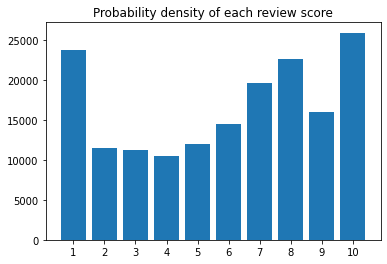

In [24]:
ratings=review_data['review_rating'].to_numpy()
print(f'Mean: {round(ratings.mean(),1)}')
print(f'Median: {round(np.median(ratings),1)}')

plt.title("Probability density of each review score")
plt.bar([1,2,3,4,5,6,7,8,9,10], np.histogram(ratings,density=False)[0], align='center')
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.show()

In [11]:
year_list=[]
for date in review_data['review_date']:
  year_list.append(date.split(' ')[-1])

years=['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']
#review_data['review_rating'][year_list=='2010']
year_dfs=[]
for year in years:
  year_dfs.append(review_data[pd.Series(year_list)==year])

In [22]:
# see trends for users leaving reviews
review_count=[]
review_mean=[]
for year in year_dfs:
  review_count.append(year.shape[0])
  review_mean.append(year['review_rating'].to_numpy().mean())

In [23]:
review_count
review_mean

[6.556345177664975,
 6.330494728304947,
 6.2878547759688805,
 6.079274004683841,
 6.074350257703696,
 6.062678062678063,
 6.0445020522791095,
 5.77830150345388,
 5.821600398164022,
 5.7893035043257886,
 5.908352668213457,
 5.768303540853366,
 5.599712540424003]

# Text analysis

In [48]:
review_data.head(20)

,review_title,review_rating,review_date,review_body,movie_title
0,A loving and charming depiction of losing a mo...,8,17 May 2013,As a film lover I can't help immensely enjoyin...,Mamma Gógó
1,"so true,",8,4 September 2014,This movie is so true showing the heartbreakin...,Mamma Gógó
2,Warning signs of a bad movie,1,11 March 2015,I just had a good laugh at sddavis63's review ...,Second Chances
3,A Weak Cast Offering Weak Performances In A Dr...,1,29 January 2010,"By the time ""Second Chances"" is finished, all ...",Second Chances
4,Moderately entertaining,6,3 January 2017,A reporter who made an error of judgement find...,Second Chances
5,Soap Opera or Thriller?,4,11 January 2017,"I'm not too sure what the writers, Angelique P...",Second Chances
6,some problems in TV movie,5,25 April 2019,Boston serial killer Max Hersog has been in pr...,Second Chances
7,"Boring, predictable and acting was not great",3,11 November 2020,I had an interest in seeing this movie due to ...,Second Chances
8,Melissa George and everything else.,3,29 September 2021,The movie is straight trash but Melissa George...,Second Chances
9,"""Be Aware and Keep Your Eyes Open!""",1,5 September 2017,It is easy to tell when the protagonist in a c...,Second Chances


In [ ]:
# Get rid of helpfullness comment
for i,review_body in enumerate(review_data['review_body']):
  if review_body.find('\n                \n                    ')!=-1:
    review_data['review_body'].iloc[i]=review_body[:review_body.find('\n                \n                    ')]
review_data.to_csv('review_data_clean.csv')

In [49]:
review_data.to_csv('review_data_clean.csv')

In [ ]:
# DO A WORD CLOUD OF REVIEW CORPUS AFTER PREPROCESSING